# <font color='blue'>**Notebook that aims to predict both the number of satellite launch and the investment in private new space in the US**</font>
- Investment data comes from an extensive gathering (scraping) of investments information in new space companies available thanks to the datasource "Crunchbase".
- Launch data come from the union of US conserned scientists that gather all satellite launch and purpose since more than 30 years.
- The modelling choice is made between VAR and VECM model, the cointegration test result however points toward choosing a VECM model

# Importing libraries

In [2]:
import pandas as pd
import numpy as np

#### Plotting libraries #####
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm


### Display all columns in a pandas dataset
pd.set_option('display.max_columns', None)

import re
import datetime
from difflib import SequenceMatcher

import matplotlib as mpl
import matplotlib.pyplot as plt

## Statistical analysis library
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.stats.stattools import durbin_watson

# <font color='blue'>Loading datasets and data preparation</font>

## Loading Launch dataset

In [3]:
df_launch = pd.read_csv('yourPATH/launch_2000_2020.csv', sep=';')

In [4]:
df_launch.head(2)

,Unnamed: 0,Current Official Name of Satellite,Country of Operator/Owner,Operator/Owner,Users,Purpose,Detailed Purpose,Class of Orbit,Launch Mass (kg.),Dry Mass (kg.),Date of Launch,Expected Lifetime (yrs.),Contractor,Country of Contractor,Launch Vehicle,Comments,Country of Operator/Owner_agg,Country of Contractor_agg,Launcher_country,Purpose_agg
0,0,1HOPSAT,USA,Hera Systems,Commercial,Earth Observation,Technology Development,LEO,22.0,NaN,2019,0.5,Hera Systems,USA,PSLV,Pathfinder for planned earth observation const...,USA,USA,India,earth_observation_and_surveillance
1,1,3Cat-1,Spain,Universitat Politècnica de Catalunya,Civil,Technology Development,NaN,LEO,4.0,NaN,2018,NaN,Universitat Politècnica de Catalunya,Spain,PSLV,Student built.,EU,EU,India,increase_mission_performance_and_technology


## <font color='blue'> Data_prep for USA number of launch </font>
- The objective is to end up with a dataset with the year as index and the number of launch dicrimined by country as a variable

In [5]:
df_launch.set_index(['Launcher_country', 'Date of Launch', 'Purpose_agg'], inplace = True)

In [6]:
list_region = ['USA', 'EU', 'Russia', 'Japan', 'China', 'India', 'ROW'] # List the region that we want to have as variables
list_df = []
i=0
##### Create a dataframe for each region and append it into a list : list_df
while i<len(list_region):
    name =  list_region[i]
    replace_name = 'nb_launch_'+name # Rename the variable as nb_launch_country
    name = df_launch.xs(list_region[i],level=0) # Select the data only for the region considered 
    name = name.groupby(level=0).count() # 
    name.rename(columns = {'Unnamed: 0':replace_name}, inplace = True)
    name = name[replace_name]
    name = name.reset_index()
    name['Date of Launch'] = pd.to_datetime(name['Date of Launch'], format='%Y')
    if len(name)<21: 
        ############## If some years are not present in the dataframe, the latter will be less than len (21) number 
        ############## of observation if there is at least one launch for each year
        ############## The rest of the if statement add create a year if not present and fill it with 0 value 
        ############## as there was 0 launch.
        r = pd.date_range(start=datetime.datetime.strptime('2000', '%Y'), end=datetime.datetime.strptime('2020', '%Y'))
        name = name.set_index('Date of Launch').reindex(r).fillna(0).rename_axis('Date of Launch').reset_index()
        name['Date of Launch'] = pd.to_datetime(name['Date of Launch']).dt.strftime('%Y')
        name = name.groupby('Date of Launch').sum()
        name = name.reset_index()
        list_df.append(name)
    else:
        ##### All year was present simply convert dates to date format and add it to the list of df
        name['Date of Launch'] = pd.to_datetime(name['Date of Launch']).dt.strftime('%Y')
        list_df.append(name)
    i=i+1

In [7]:
### Append the data from the list of dataframe into a single data frame
data_launch = pd.merge(list_df[0],list_df[1])
data_launch = pd.merge(data_launch,list_df[2])
data_launch = pd.merge(data_launch,list_df[3])
data_launch = pd.merge(data_launch,list_df[4])
data_launch = pd.merge(data_launch,list_df[5])
data_launch = pd.merge(data_launch,list_df[6])
data_launch.head(5)

,Date of Launch,nb_launch_USA,nb_launch_EU,nb_launch_Russia,nb_launch_Japan,nb_launch_China,nb_launch_India,nb_launch_ROW
0,2000,10,9,9,0.0,0.0,0.0,1.0
1,2001,8,4,5,0.0,0.0,0.0,1.0
2,2002,8,10,6,1.0,0.0,0.0,5.0
3,2003,14,3,5,0.0,1.0,0.0,4.0
4,2004,9,3,6,0.0,4.0,0.0,6.0


## <font color='blue'>Loading private investment data</font>

In [10]:
df_comp_wmv = pd.read_excel('yourPATH/data_private_investment_wmv.xlsx', 
                           encoding='ISO-8859-1')

## <font color='blue'>Preparing for USA private investments isolation</font>

In [14]:
def select_country(df, country):
    '''A function that return a sub data according to the desired country and sub market of the space economy'''
    df = df[df['Comp_country']==country]
    
    return df

In [15]:
Investment_US = select_country(df_comp_wmv, 'USA')

In [16]:
# Droping useless variables and deleting the last year of investments (2021 as the year has just began)
invest_us = Investment_US.groupby('Announced Date').sum()
invest_us = invest_us.drop(['Announced_date', 'Comp_subsector'], axis=1)
invest_us = invest_us[:-1]

## <font color='blue'>Adding US investments to the launch dataset</font>

In [17]:
us_investment_money = invest_us['Money_clean'].tolist()

In [18]:
data_launch['Invest_in_US_private_space'] = us_investment_money

In [19]:
data_launch.head(2)

,Date of Launch,nb_launch_USA,nb_launch_EU,nb_launch_Russia,nb_launch_Japan,nb_launch_China,nb_launch_India,nb_launch_ROW,Invest_in_US_private_space
0,2000,10,9,9,0.0,0.0,0.0,1.0,30000000
1,2001,8,4,5,0.0,0.0,0.0,1.0,3000000


In [20]:
data_launch_ind = data_launch.set_index('Date of Launch')

# <font color='blue'>Time series visualisation and Exploration</font>
- Compare the dynamics in the various world regions, specifically the US 
- Have a first idea of the potential stationnarity of the series
- Check a possible correlation between series

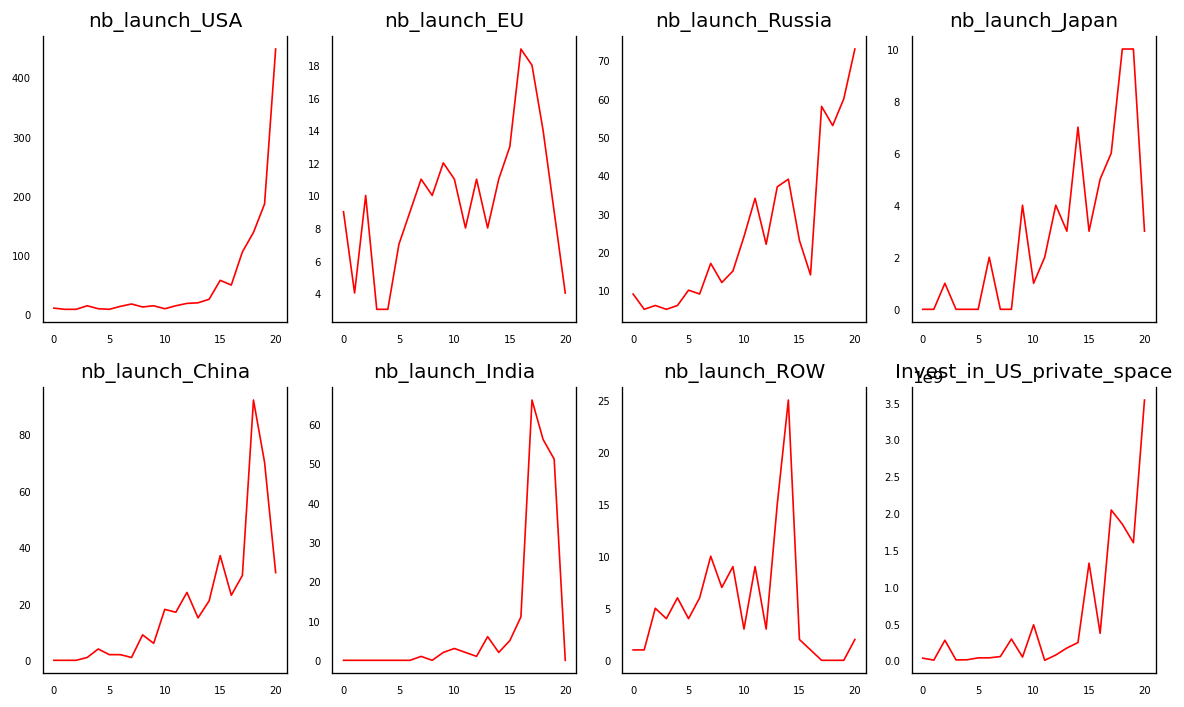

In [21]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=4, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = data_launch[data_launch_ind.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    ax.set_title(data_launch_ind.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    
    plt.tight_layout()

### <font color = 'red'>Interpretation</font>
- The US are by far the main launchers with more than 400 hundred launched in 2020 followed by the Chinese with almost 100 launches. Russia and India follow.
- One can see a drastic increase in the US quantities of launch since 2015. In the same time we see in Europe a drastic decrease in the launch activity. Can it be due to the concurrence that new space actors (spaceX, Blue Origin) do to classic launchers such as Ariane ...
- China and Russia also experience an upward trend but with much more volatility.
- The private investment in US start to rise dramatically since 2010 (seasonnality is hard to assess). 
- <font color='green'>**Could there be a link between the investment and the quantity of launch, and vice versa ? Could one help predict the other ?**</font>


- Just at the look of the data we can safely say that they are not stationnary. Therefore we will need to transform the data by differentiation in order to stationnarize the series if we want to jump to prediction. 
- It is unclear if there is a seasonnality within the data patter as the cycles of boom and burst are not regular.

### Check the correlation between the launch of the various world regions
- Corroborate visualization with more formal correlation patterns

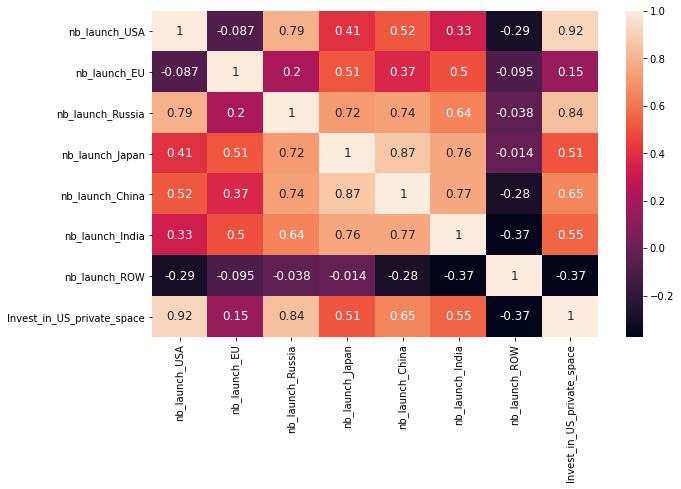

In [117]:
correlation = data_launch_ind.corr(method="pearson")
sns.heatmap(correlation, xticklabels = data_launch_ind.columns.values, yticklabels = data_launch_ind.columns.values,
           annot = True, annot_kws={'size':12})
heat_map = plt.gcf()
heat_map.set_size_inches(10,6)
plt.xticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.show()

#correlation

### <font color='red'>Interpretation</font>
The correlation between US space investments and the number of launch is quite high. The number of launch in the US and in Russia are also correlated. However correlation does not mean causality. Our next aim (after displaying a zoom paralleling the US investment and launches curves will be to perform granger causality tests on the data to check if adding the past values of the investments reduces the mean square error of the launches prediction (based uniquely on its own past values).

### Detail the curves for US launch and private investment into space sector

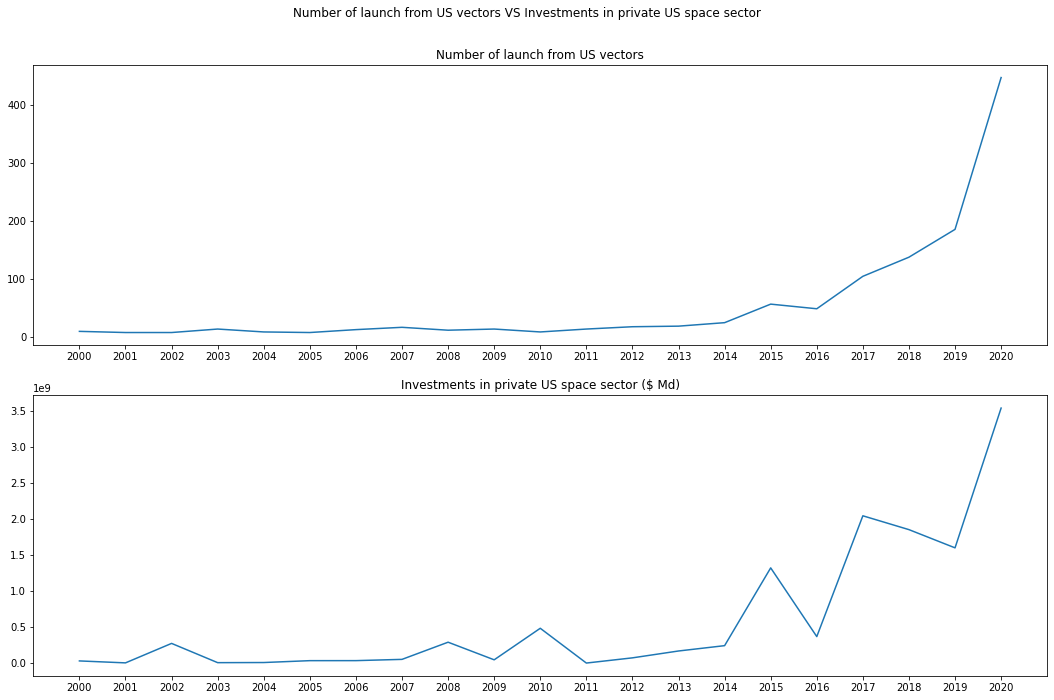

In [107]:
fig, axs = plt.subplots(2,figsize=(15,10))

fig.suptitle('Number of launch from US vectors VS Investments in private US space sector')


axs[0].plot(data_launch['Date of Launch'], data_launch['nb_launch_USA'])
axs[0].set_title('Number of launch from US vectors')
axs[1].plot(data_launch['Date of Launch'], data_launch['Invest_in_US_private_space'])
axs[1].set_title('Investments in private US space sector ($ Md)')

fig.tight_layout(pad=2)
fig.subplots_adjust(top=0.9)

fig.savefig("Cross plot of number of launch and investments in private US sector.png")

### <font color='red'>Interpretation</font>
What we can suspect :
- A structural change within both series starting around 2014 (probably caused by the space spatial act) 
- A causality (to be tested thanks to a granger causality test)
- A co-Integration between both series to test if a long run relationship exist between the two variables

# <font color='blue'>Testing for the series structure to orient model choice</font>

## Testing for autocorrelation

### We first check at the Autocorrelation functions and partial autocorrelation function for the launch in the US & investments and check at the level of integration of the series

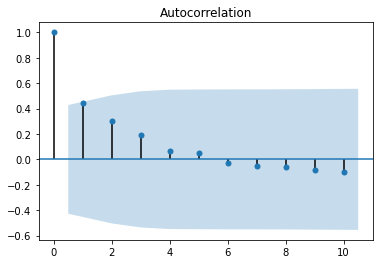

In [121]:
ax = sm.tsa.graphics.plot_acf(data_launch['nb_launch_USA'], lags=10)

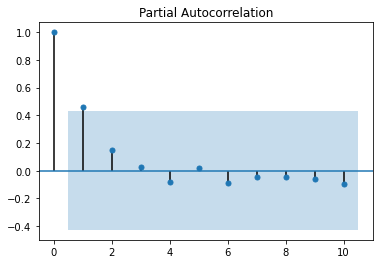

In [32]:
az = sm.tsa.graphics.plot_pacf(data_launch['nb_launch_USA'], lags=10)

### We test for the presence of Unit Root thanks to Augmented Dickey Fuller Test (Null hypothesis = Unit Root, the serie is non_stationnary)

In [126]:
variables = ['nb_launch_USA', 'Invest_in_US_private_space', 'nb_launch_Russia', 'nb_launch_China']
for variable in variables:
    X = data_launch[variable].values
    #X = X[:]
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

ADF Statistic: 2.206736
p-value: 0.998888
Critical Values:
	1%: -4.138
	5%: -3.155
	10%: -2.714
ADF Statistic: 3.677019
p-value: 1.000000
Critical Values:
	1%: -4.138
	5%: -3.155
	10%: -2.714
ADF Statistic: -0.176685
p-value: 0.941244
Critical Values:
	1%: -4.138
	5%: -3.155
	10%: -2.714
ADF Statistic: 3.625096
p-value: 1.000000
Critical Values:
	1%: -4.069
	5%: -3.127
	10%: -2.702


### <font color='red'>Interpretation</font>
We clearly accept the null hypothesis of unit root, hence we conclude that each serie that we aim to investigate and link to the others is non stationnary.

### Differentiating until we reach stationnarity 

In [23]:
data_diff = data_launch_ind.diff().dropna()

In [24]:
variables = ['nb_launch_USA', 'Invest_in_US_private_space']
for variable in variables:
    X = data_diff[variable].values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.254316
p-value: 0.996340
Critical Values:
	1%: -4.223
	5%: -3.189
	10%: -2.730
ADF Statistic: 1.222303
p-value: 0.996136
Critical Values:
	1%: -4.223
	5%: -3.189
	10%: -2.730


#### Let's repeat the operation until the data show stationnarity

In [27]:
data_diff = data_diff.diff().dropna()
variables = ['nb_launch_USA', 'Invest_in_US_private_space']
for variable in variables:
    X = data_diff[variable].values
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.112845
p-value: 0.000000
Critical Values:
	1%: -3.964
	5%: -3.085
	10%: -2.682
ADF Statistic: -4.327430
p-value: 0.000398
Critical Values:
	1%: -4.069
	5%: -3.127
	10%: -2.702


### <font color='red'>Interpretation</font>
We had to differentiate the series 4 times before we reject the null hypothesis hence the level of integration of the variables are:
- US investments and launch are both I(4)

#### Visualization

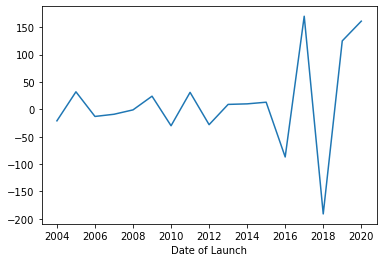

In [28]:
data_diff['nb_launch_USA'].plot()

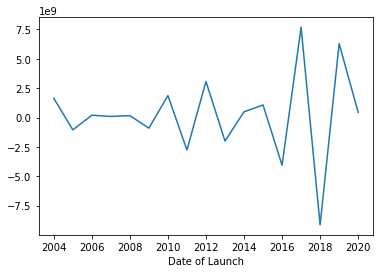

In [29]:
data_diff['Invest_in_US_private_space'].plot()

# <font color='blue'>We theoretically suspect that each serie can influence the other, we are therefore Setting up a VAR model to fit the data and search for the optimal number of lag to integrate to a granger causality test</font>

## Splitting the dataset

<font color='red'>Limitation and warnings due to the limitation in the quantity of data</font>

- We have a limited number of available data for this project which is highly limitating in this context. Therefore we will chose to increase the size of the training set and try to predict only the 3 last years. Moreover, 2014 seems to be a structural break in the pattern of the data and we want the training set to have data both before and after this date.
- Granger causality tests are based on asymptotic properties of the distribution, hence the power of the test is affected by the law number of the available sample

In [30]:
n_obs=3
X_train, X_test = data_diff[0:-n_obs], data_diff[-n_obs:]

#### Let_us discard the unused var

In [31]:
X_train = X_train[['nb_launch_USA', 'Invest_in_US_private_space']]
X_test = X_test[['nb_launch_USA', 'Invest_in_US_private_space']]

In [33]:
model = VAR(X_train)
for i in [1,2,3,4,5]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  48.733278768438765
BIC :  48.994024625728706
FPE :  1.4857536485811463e+21
HQIC:  48.6796837543601 

Lag Order = 2
AIC :  47.218110341277345
BIC :  47.62219921610068
FPE :  3.5763695894727406e+20
HQIC:  47.06850216355289 

Lag Order = 3
AIC :  46.36732071430329
BIC :  46.87373287968303
FPE :  2.177808514322952e+20
HQIC:  46.04809877992722 

Lag Order = 4
AIC :  14.968994682516056
BIC :  15.51364784990534
FPE :  31260711.41977825
HQIC:  14.371511485408698 

Lag Order = 5
AIC :  -20.749183126959743
BIC :  -20.267078604582316
FPE :  7.337139847106473e-10
HQIC:  -21.789563086985037 



C:\Users\amaur\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


### <font color='red'>Interpretation</font>
- We have that the AIC criteria is the lowest for 5 lag values
- Due to the limiting number of observation increasing the number of instrument (lag values) is decreasing the degree of freedom of the model and will lead to worst estimation and predictive power. A drop in the AIC at 4 lags seems reasonnable to assume it as the optimal lag value

## Fitting the VAR Model

In [43]:
results = model.fit(maxlags=4, ic='aic')
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 26, Feb, 2021
Time:                     20:36:29
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    15.5136
Nobs:                     10.0000    HQIC:                   14.3715
Log likelihood:          -85.2237    FPE:                3.12607e+07
AIC:                      14.9690    Det(Omega_mle):     8.65843e+06
--------------------------------------------------------------------
Results for equation nb_launch_USA
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                 1.806623         1.800469            1.003           0.316
L1.nb_launch_USA                     -1.863455         0.222506           -8.375     

In [44]:
out = durbin_watson(results.resid)

for col, val in zip(X_train.columns, out):
    print(col, ':', round(val, 2))

nb_launch_USA : 1.02
Invest_in_US_private_space : 1.02


### <font color='red'>Interpretation</font>
- Launch are influenced by investments after four periods
- The investments are seems to be caused by their past values
- However the residuals for each equations are still corellated as stated by the Durbin watson test suggesting that the instrument lag in the model is still not appropriate, hence we cannot trust this model, and prediction will probably be poor.

## Check prediction accuracy

In [45]:
lag_order = results.k_ar

df_input = X_train.values[-lag_order:]

df_forecast = results.forecast(y=df_input, steps=n_obs)
df_forecast = (pd.DataFrame(df_forecast, index=X_test.index, columns=X_test.columns + '_pred'))


def invert_transformation(df, pred):
    forecast = df_forecast.copy()
    columns = df.columns
    for col in columns:
        forecast[str(col)+'_pred'] = df[col].iloc[-1] + forecast[str(col)+'_pred'].cumsum()
    return forecast

output = invert_transformation(X_train, df_forecast)

combined = pd.concat([output['nb_launch_USA_pred'], X_test['nb_launch_USA'], output['Invest_in_US_private_space_pred'], 
                      X_test['Invest_in_US_private_space']], axis=1)
combined

,nb_launch_USA_pred,nb_launch_USA,Invest_in_US_private_space_pred,Invest_in_US_private_space
Date of Launch,,,,
2018,-30.795922,-191.0,8.773853e+07,-9.148748e+09
2019,113.163647,125.0,-3.848115e+09,6.297291e+09
2020,170.939225,161.0,2.880393e+10,4.451535e+08


### <font color='red'>Interpretation</font>
- As expected the prediction of the variables (in difference) is extremely incorrect ex: -3 Billions of variation predicted in 2019 vs 6.2 Billion of actual value

## Performing the granger causality test on the variables in level with 4 lags (as proposed by the AIC criterion in the previous VAR model

In [47]:
data_launch_wmv = data_launch.dropna().set_index('Date of Launch')

In [52]:
from statsmodels.tsa.stattools import grangercausalitytests

maxlag=4
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(data_launch_wmv, variables = data_launch_wmv.columns)

,nb_launch_USA_x,nb_launch_EU_x,nb_launch_Russia_x,nb_launch_Japan_x,nb_launch_China_x,nb_launch_India_x,nb_launch_ROW_x,Invest_in_US_private_space_x
nb_launch_USA_y,1.0000,0.0249,0.0096,0.1506,0.0000,0.0000,0.0715,0.0000
nb_launch_EU_y,0.1154,1.0000,0.1528,0.0587,0.0001,0.0327,0.0000,0.0511
nb_launch_Russia_y,0.0000,0.0129,1.0000,0.0024,0.0000,0.0000,0.0000,0.0000
nb_launch_Japan_y,0.0851,0.0005,0.0005,1.0000,0.0000,0.0000,0.4962,0.0000
nb_launch_China_y,0.0017,0.0000,0.0000,0.0027,1.0000,0.0000,0.0000,0.0000
nb_launch_India_y,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
nb_launch_ROW_y,0.1792,0.2026,0.5469,0.0296,0.0341,0.0056,1.0000,0.0000
Invest_in_US_private_space_y,0.0000,0.0287,0.0003,0.0000,0.0000,0.0000,0.0000,1.0000


### <font color='red'>Interpretation</font>
- It seems that each serie causes the other if were consider a four order lag value in time. However we already stated that the number of observation is low hence we can poorly rely on this test. 
- <font color='red'>It however is an intuation that series can influence each others at rather short term. We now want to test if there is a long run relationship between the two</font>

# <font color='blue'>Testing for co-integration between investments and number of launch in the US</font>
- Two series integrated of order D are cointegrated if a linear combination of the two if the residuals for their linear combination is of order B<D
- We regress the invest on the number of launch get their results and test the integration results of the residuals

In [53]:
import statsmodels.tsa.stattools as ts

In [59]:
ols_results = sm.OLS(data_launch_ind['Invest_in_US_private_space'], data_launch_ind['nb_launch_USA']).fit()
res = ols_results.resid
res_diff = res.diff().dropna()
res_diff_2 = res_diff.diff().dropna()

In [62]:
result_test = adfuller(res_diff_2)
result_test

(-5.674414366520105,
 8.77159457460263e-07,
 7,
 11,
 {'1%': -4.223238279489106,
  '5%': -3.189368925619835,
  '10%': -2.729839421487603},
 453.2741167213957)

### <font color='red'>Interpretation</font> 
- Here our series are integrated of order 4 and their linear combinaison id integrated of order 2. 
- We could therefore state for cointegration and orient the modelling toward a VECM

# Vector Error Correction Model estimation

In [66]:
from statsmodels.tsa.vector_ar.vecm import VECM

In [63]:
# Test for the presence of the space act in 2015, however adding variable decrease the few degree of freedom we have so we
# won't use it in the final model
data_launch_ind['space_act'] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1]
data_launch_ind.head(2)

,nb_launch_USA,nb_launch_EU,nb_launch_Russia,nb_launch_Japan,nb_launch_China,nb_launch_India,nb_launch_ROW,Invest_in_US_private_space,space_act
Date of Launch,,,,,,,,,
2000,10,9,9,0.0,0.0,0.0,1.0,30000000,0
2001,8,4,5,0.0,0.0,0.0,1.0,3000000,0


# Setting up the model parameters
- We wish to predict the last three years (it is also a reasonnable time span at wish you want to be able to make prediction and leaves enough training data as we are in level and not in difference)
- The number optimal of lags that we stated were of 4 as suggested by the AIC criterion
- The cointegration order suggested by the residual of the linear combinaition of the two series is of 2
- The dynamic in the data suggest starting in 2014 a linear trend within the long run relationship

In [67]:
n_obs=3
X_train, X_test = data_launch_ind[0:-n_obs], data_launch_ind[-n_obs:]
X_test_subset = X_test[['nb_launch_USA', 'Invest_in_US_private_space', 'space_act']]
X_train_subset = X_train[['nb_launch_USA', 'Invest_in_US_private_space', 'space_act']]

In [68]:
vecm = VECM(endog = X_train_subset[['nb_launch_USA', 'Invest_in_US_private_space']], k_ar_diff = 4, coint_rank = 2, deterministic = 'li')
vecm_fit = vecm.fit()
vecm_fit.predict(steps=3)

C:\Users\amaur\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


array([[1.21458955e+02, 7.59297830e+08],
       [2.14847567e+02, 2.10508443e+09],
       [3.48031122e+02, 2.84810685e+09]])

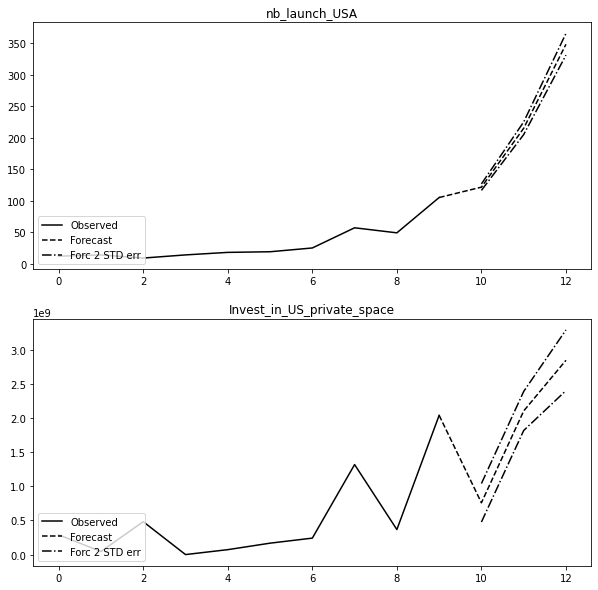

In [69]:
vecm_fit.plot_forecast(steps = 3, n_last_obs = 10)

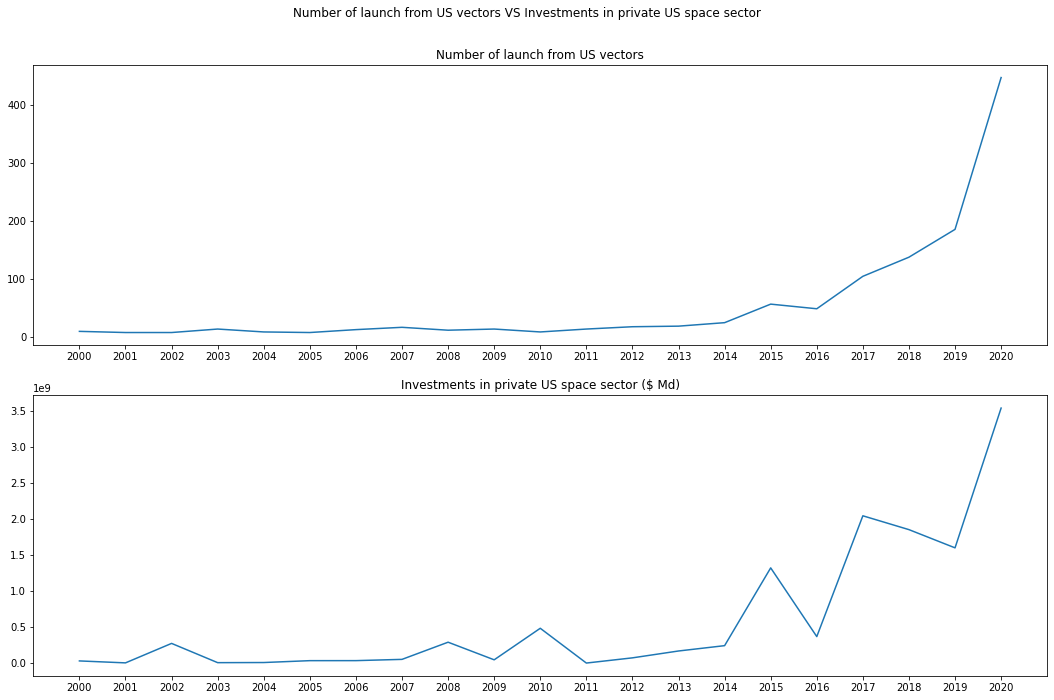

In [344]:
fig, axs = plt.subplots(2,figsize=(15,10))

fig.suptitle('Number of launch from US vectors VS Investments in private US space sector')


axs[0].plot(data_launch['Date of Launch'], data_launch['nb_launch_USA'])
axs[0].set_title('Number of launch from US vectors')
axs[1].plot(data_launch['Date of Launch'], data_launch['Invest_in_US_private_space'])
axs[1].set_title('Investments in private US space sector ($ Md)')

fig.tight_layout(pad=2)
fig.subplots_adjust(top=0.9)

fig.savefig("Cross plot of number of launch and investments in private US sector.png")

# <font color='red'>**Conclusion**</font> 
- As suggested by our battery of test, the VECM model seems the most suited for the data. Indeed, the prediction is rather accurate either for the investment level aswell as for the launch activity
    - the predicted investments at 3 year of distance is of 3 Billions while the actual value is of 3.5 Billion
    - the predicted launch at 3 year of distance is of 350 while the actual value is of 450
    
    
- Considering the complexity of the phenomenon and the small number of observation these can be considered as fairly good prediction results